Importing relevant packages and modules

In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline

In [2]:
import sys
from pathlib import Path

# Plotting
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('bioAI.mplstyle')
import copy

'''
CUSTOM PACKAGES
'''
# avoid adding multiple relave paths to sys.path
sys.path.append("../src") if "../src" not in sys.path else None

from plotting_functions import *
from synthetic_grid_cells import GridModule, rotation_matrix
from methods import multiimshow, PCA_UMAP
from Experiment import Experiment
from stats import *

In [3]:
base_path = "/mnt/WD12TB-HDD"
experiment = Experiment(name="gg-3ME", base_path=base_path)
experiment.setup()

nx,ny = 2.2,2.2 # board size
boxsize=(nx,ny)
res = 200

# initialize board
xx, yy = np.meshgrid(
    np.linspace(-nx/2, nx/2, res),
    np.linspace(-ny/2, ny/2, res),
)
board = np.stack([xx, yy], axis=-1)

# set grid module parameters
f = 1/0.838 # spacing determined by the learned torus cells
ncells=604

Experiment <gg-3ME> already EXISTS. Loading experiment settings!
Loading experiment details
This experiment has ALREADY been setup - SKIPPING.


In [4]:
# default module
default = GridModule(ncells,orientation_offset=0, center=np.zeros(2), f=f)
# coherent modules
c_phase_shift = copy.deepcopy(default)
c_phase_shift.phases -= 0.2
c_orientation_shift = GridModule(ncells,orientation_offset=default.orientation_offset + 15, center=default.center, f=default.f)
c_orientation_shift.phases = copy.deepcopy(default.phases)
# incoherent modules
i_phase_shift = GridModule(ncells,orientation_offset=default.orientation_offset, center=default.center, f=default.f)
i_orientation_shift = []
for i in range(ncells):
    i_orientation_shift.append(GridModule(1,orientation_offset=np.random.uniform()*30, center=default.center, f=default.f))
    i_orientation_shift[-1].phases = default.phases[i:i+1]

In [5]:
default_ratemaps = default(board.reshape(-1,2)).reshape(res,res,ncells)
cps_ratemaps = c_phase_shift(board.reshape(-1,2)).reshape(res,res,ncells)
cos_ratemaps = c_orientation_shift(board.reshape(-1,2)).reshape(res,res,ncells)
ips_ratemaps = i_phase_shift(board.reshape(-1,2)).reshape(res,res,ncells)
ios_ratemaps = np.array([module(board.reshape(-1,2)).reshape(res,res) for module in i_orientation_shift]).transpose(1,2,0)

(<Figure size 900x600 with 1 Axes>, <Axes: >)

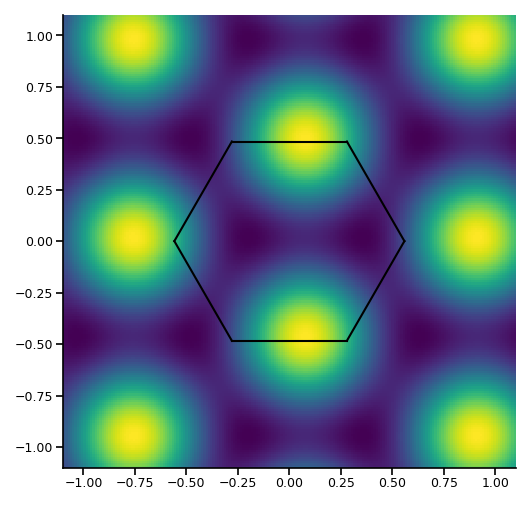

In [6]:
fig,ax = plt.subplots()
ax.imshow(default_ratemaps[:,:,0], origin="lower", extent=(-nx/2,nx/2,-ny/2,ny/2))
default.unit_cell.plot(fig,ax, color="k", linewidth=1)

(0.9133903346496972, 0.0068576713331142125)


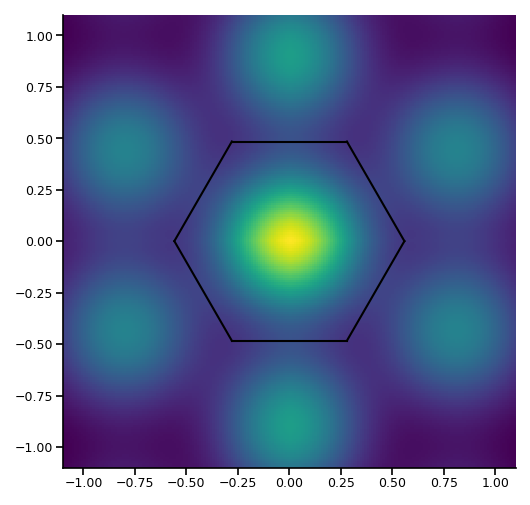

In [7]:
fig,ax = plt.subplots()
ax.imshow(correlate(default_ratemaps[...,0], default_ratemaps[...,0], mode='same'), origin="lower",extent=(-nx/2,nx/2,-ny/2,ny/2))
default.unit_cell.plot(fig,ax, color="k", linewidth=1)
print(grid_spacing(default_ratemaps[...,0]))

## Phase shift statistics

In [8]:
cps_calculated = np.array([calculate_phase_shift(default_ratemaps[...,i],cps_ratemaps[...,i],boxsize=boxsize) for i in range(ncells)])
ips_calculated = np.array([calculate_phase_shift(default_ratemaps[...,i],ips_ratemaps[...,i],boxsize=boxsize) for i in range(ncells)])

In [9]:
from scipy.stats import gaussian_kde

bw_method = 0.1
noise = np.random.normal(0,0.01,size=cps_calculated.shape)*0
cps_kde = gaussian_kde((cps_calculated+noise).T)#, bw_method=bw_method)
ips_kde = gaussian_kde((ips_calculated+noise).T)#, bw_method=bw_method)
cps_kde_map = cps_kde(board.reshape(-1,2).T).reshape(res,res)
ips_kde_map = ips_kde(board.reshape(-1,2).T).reshape(res,res)

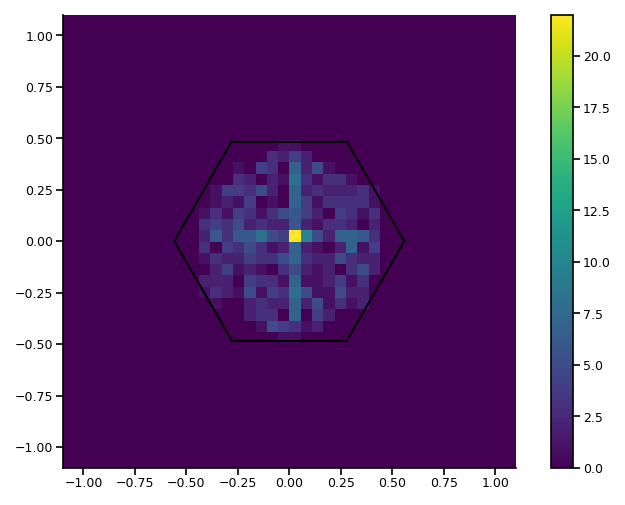

In [10]:
hist = scipy.stats.binned_statistic_2d(*ips_calculated.T,values=np.empty_like(cps_calculated[:,0]),
statistic="count",bins=40,range=[[-nx/2,nx/2],[-ny/2,ny/2]]).statistic

fig,ax = plt.subplots()
ax.imshow(hist, origin='lower', extent=[-nx/2,nx/2,-ny/2,ny/2])
default.unit_cell.plot(ax=ax, color='k', linewidth=1)
# add colorbar
cbar = fig.colorbar(ax.images[0], ax=ax)

In [11]:
panesize = set_size(width=345, mode='tall')
figsize=(panesize[0]/3,panesize[1]/5)
print(figsize)
figsize=(min(figsize),min(figsize))
figsize=np.array(figsize)

(1.59125501591255, 1.5220700152207)


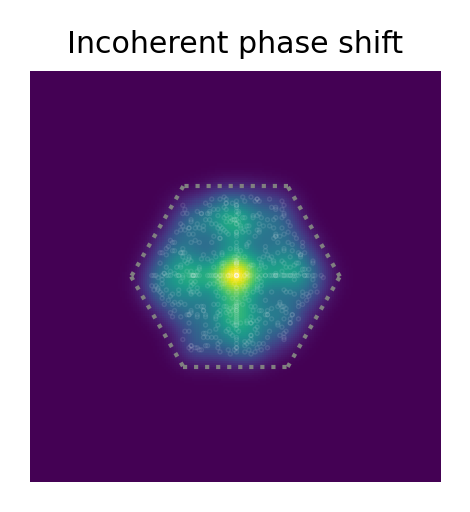

In [12]:
fig,ax = plt.subplots(figsize=figsize,dpi=300)
ax.imshow(ips_kde_map, origin='lower', extent=[-nx/2,nx/2,-ny/2,ny/2])
ax.scatter(*ips_calculated.T, s=0.1, color='white', alpha=0.1, marker=matplotlib.markers.MarkerStyle(marker='h', fillstyle='none'))
default.unit_cell.plot(ax=ax, color='grey', linewidth=1, ls=':')
ax.set_title("Incoherent phase shift")
ax.axis('off')
plt.subplots_adjust(left=0, bottom=0, right=1, top=0.9, wspace=0, hspace=0)
fig.savefig(experiment.paths['experiment'] / "plots/phase_shift_incoherent")

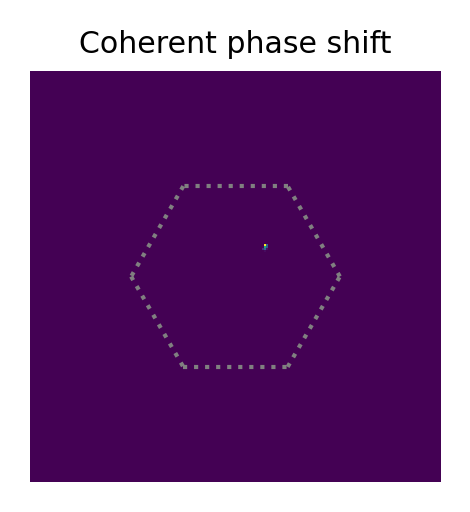

In [13]:
fig,ax = plt.subplots(figsize=figsize,dpi=300)
ax.imshow(cps_kde_map, origin='lower', extent=[-nx/2,nx/2,-ny/2,ny/2])
default.unit_cell.plot(ax=ax, color='grey', linewidth=1, ls=':')
ax.set_title("Coherent phase shift")
ax.axis('off')
plt.subplots_adjust(left=0, bottom=0, right=1, top=0.9, wspace=0, hspace=0)
fig.savefig(experiment.paths['experiment'] / "plots/phase_shift_coherent")

## Grid Orientation statistics

In [14]:
low_res = 64

# initialize board
xx, yy = np.meshgrid(
    np.linspace(-nx/2, nx/2, low_res),
    np.linspace(-ny/2, ny/2, low_res),
)
low_res_board = np.stack([xx, yy], axis=-1)

lr_default_ratemaps = default(low_res_board.reshape(-1,2)).reshape(low_res,low_res,ncells)
lr_cos_ratemaps = c_orientation_shift(low_res_board.reshape(-1,2)).reshape(low_res,low_res,ncells)
lr_ios_ratemaps = np.array([module(low_res_board.reshape(-1,2)).reshape(low_res,low_res) for module in i_orientation_shift]).transpose(1,2,0)

In [15]:
coherent_orientation_calculated = np.array([calculate_orientation_shift(lr_default_ratemaps[...,i],lr_cos_ratemaps[...,i]) for i in range(ncells)])
incoherent_orientation_calculated = np.array([calculate_orientation_shift(lr_default_ratemaps[...,i],lr_ios_ratemaps[...,i]) for i in range(ncells)])

In [16]:
cos_calculated = np.array([grid_orientation(cos_ratemaps[...,i])[0] for i in range(ncells)])
ios_calculated = np.array([grid_orientation(ios_ratemaps[...,i])[0] for i in range(ncells)])
# -----------------
# make circular by extending the orientations by +- 30 degrees
#cos_calculated = np.concatenate([cos_calculated,cos_calculated+30*np.pi/180,cos_calculated-30*np.pi/180])
#ios_calculated = np.concatenate([ios_calculated,ios_calculated+30*np.pi/180,ios_calculated-30*np.pi/180])
# -----------------

In [17]:
from scipy.stats import gaussian_kde

bw_method = 0.02
hist_range = [0,30]

cos_kde = gaussian_kde(cos_calculated*180/np.pi, bw_method=bw_method)
ios_kde = gaussian_kde(ios_calculated*180/np.pi, bw_method=bw_method)
cos_kde_map = cos_kde(np.linspace(*hist_range,res))
ios_kde_map = ios_kde(np.linspace(*hist_range,res))

10.720175616595013 21.647881348115607


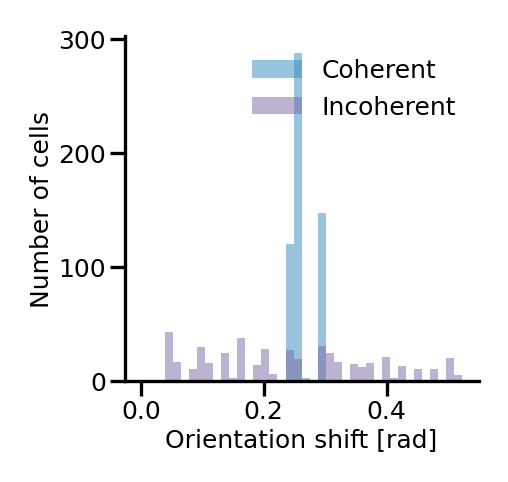

In [18]:
fig,ax = plt.subplots(figsize=figsize,dpi=300)

hist_range_rad = [0,30*np.pi/180]
ax.hist(coherent_orientation_calculated, bins=40, range=hist_range_rad, alpha=0.5, label='Coherent');
ax.hist(incoherent_orientation_calculated, bins=40, range=hist_range_rad, alpha=0.5, label='Incoherent');
print(np.mean(coherent_orientation_calculated*180/np.pi),np.mean(incoherent_orientation_calculated*180/np.pi))
ax.legend()
ax.set_xlabel("Orientation shift [rad]")
ax.set_ylabel("Number of cells")
#plt.plot(np.linspace(*hist_range,res), cos_kde_map*res)
#plt.plot(np.linspace(*hist_range,res), ios_kde_map*res)
fig.savefig(experiment.paths['experiment'] / "plots/orientation_shift", bbox_inches='tight')